<a target="_blank" href="https://colab.research.google.com/github/16820AdvancedCV/hw6/blob/main/HW6.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Environment Set-up with Google Colab

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = True

In [2]:
if using_colab:
    # install everything
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib os
    ! pip install open3d
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir ckpts
    !wget -P ckpts https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    ! pip install gdown
    ! gdown 1K375xNjWAwZ7kmhjTuJccC3y6Ik5tN4q #download dataset from gdrive
    ! unzip images.zip

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: w

## Environment Set-up without Google Colab



If you're not running on Google Colab, use the [prep_no_colab.sh](prep_no_colab.sh) script to install the right libraries, pull the model checkpoint and download the data. This script was tested on Ubuntu Linux only. After running the script your folder should look something like this:
```
├── images
│   ├── dataset
│   │   ├── train
|   |   ├── test
|   |   ├── val
│   │   ├── transforms_train.json
│   │   ├── transforms_test.json
│   │   ├── transforms_val.json
├── ckpts
│   ├── sam_vit_h_4b8939.pth
```

Our recommended method for loading iPython notebooks on your local computer is to use a Visual Studio Code plugin, [here](https://code.visualstudio.com/docs/datascience/jupyter-notebooks) is a short tutorial on how to do that. Are you having issues setting up your system? Problems with Cuda versions? Use Colab instead, or ask a TA if you really want to use your own compute.

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import os


In [4]:
def show_mask(mask, ax, random_color=False):
    # This function is used to visualize the mask on the image in a matplotlib axis.
    # bool mask: (H, W). True for each pixel that belongs to the object.
    # ax: matplotlib axis
    # random_color: if True, use a random color for the mask. Otherwise, use blue.

    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    # This function is used to visualize the bounding box on the image in a matplotlib axis.
    # box: (4,) array. [x0, y0, x1, y1]
    # (x0, y0): top-left corner
    # (x1, y1): bottom-right corner
    # ax: matplotlib axis

    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [36]:
image = cv2.imread("/content/image_0004.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

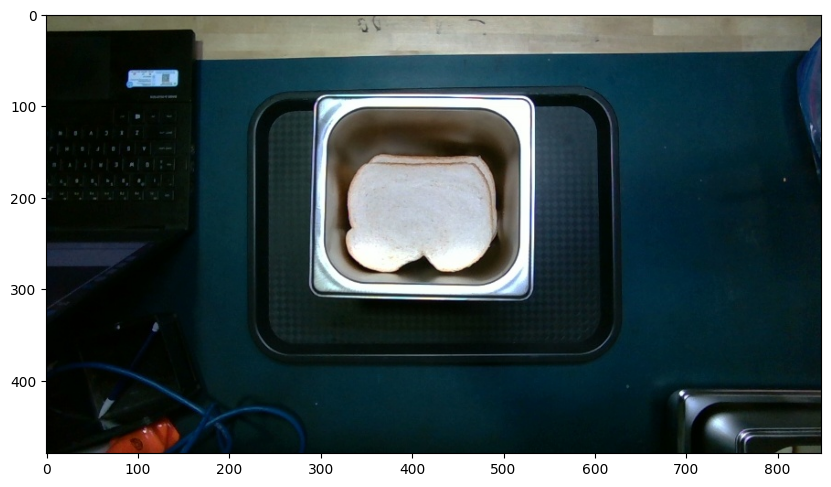

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()


#### Loading SAM [0 pts]

In [38]:
import sys
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "ckpts/sam_vit_h_4b8939.pth" # the checkpoint loaded in the setup section.
model_type = "vit_h"

device = "cuda" # loading to GPU.

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## Q2: Designing our prompt [2 point]

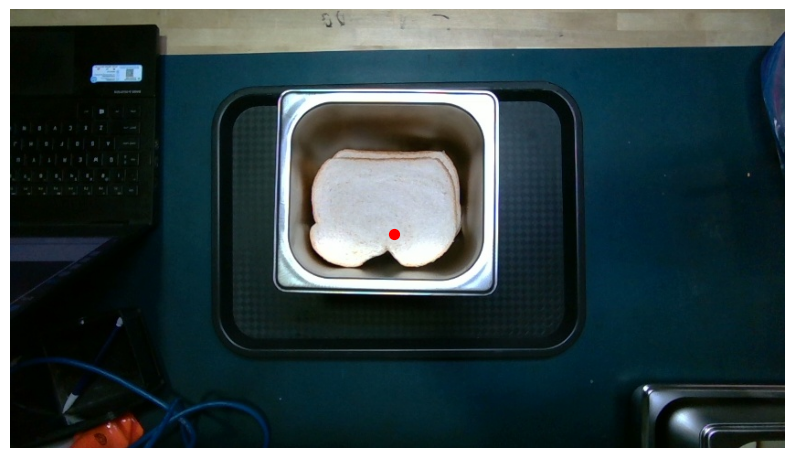

In [39]:
#TODO: YOUR CODE HERE
# add this plot to gradescope submission.
input_box = None # choose correct bounding box [2 pts]
input_box = np.array([390, 210, 450, 300])

input_pts = np.array([[420, 245]])
input_labels = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(input_pts[:, 0], input_pts[:, 1], color="red", s=50, label="Points")
# show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [40]:
# Here we're running SAM on the image with the bounding box.
predictor.set_image(image) # loading the image to the predictor.
masks, _, _ = predictor.predict(
    point_coords=input_pts,
    point_labels=input_labels,
    # box=input_box[None, :],
    box=None,
    multimask_output=False,
)
# Calling the predictor with the bounding box.
# You will not need to change any of the other arguments in this homework.


#### Visualizing the mask.

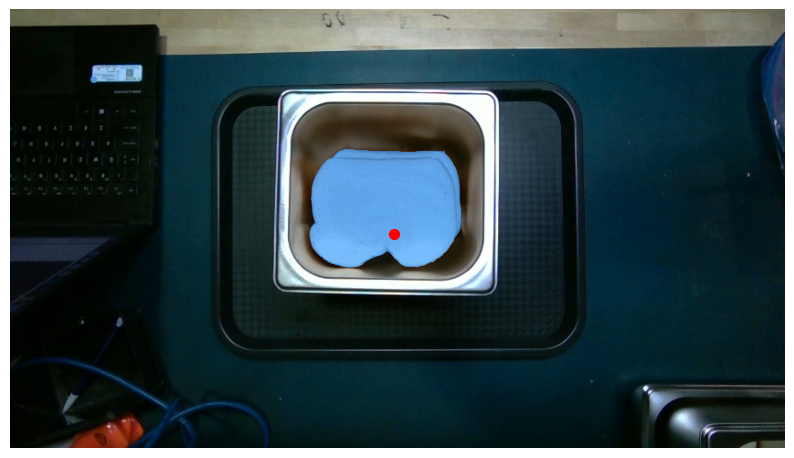

In [41]:
mask = masks[0]
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(mask, plt.gca())
# show_box(input_box, plt.gca())
plt.scatter(input_pts[:, 0], input_pts[:, 1], color="red", s=50, label="Points")
plt.axis('off')
plt.show()